### Важность инициализации

План на сегодня: разбираем проблемы инициализации весов
1. Диагностика проблем:
   - начальное распределение выхода
   - значения промежуточных активаций и нелинейности с насыщением
2. Настраиваем инициализацию весов

Впереди нас ждут разные сложные архитектуры, но перед этим задержимся подольше на MLP, чтобы получить большьше интуитивного понимания об активациях и градиентах в нейронных сетях в процессе обучения



In [1]:
import torch
from torch import nn, Tensor
from torch.nn import functional as F
import matplotlib.pyplot as plt

#### 1. Подготовим данные, модель и функции для обучения

Загружаем MNIST и создаём загрузчики данных:

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    'data', 
    train=True, 
    download=True,    
    transform=transforms.ToTensor(),
)
test_dataset = datasets.MNIST(
    'data', 
    train=False, 
    download=True,
    transform=transforms.ToTensor(),
)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Определим функции обучения:
1. градиенты обновляем вручную — для большей прозрачности того, что происходит
2. эпоху ограничиваем сотней батчей — просто для скорости

In [3]:
def training_step(batch: tuple[Tensor, Tensor], model: nn.Module, lr: float = 0.01) -> Tensor:
    # прогоняем батч через модель
    x, y = batch
    logits, *_ = model(x)
    # оцениваем значение ошибки
    loss = F.cross_entropy(logits, y)
    # обновляем параметры
    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param.data -= lr * param.grad
            param.grad = None
    # возвращаем значение функции ошибки для логирования
    return loss

def train_epoch(dataloader: DataLoader, model: nn.Module, lr: float = 0.01, max_batches: int = 100) -> Tensor:
    loss_values: list[float] = []
    for i, batch in enumerate(dataloader):
        loss = training_step(batch, model, lr)
        loss_values.append(loss.item())
        if i == max_batches:
            break
    return torch.tensor(loss_values).mean()

def test_epoch(dataloader: DataLoader, model: nn.Module, max_batches: int = 100) -> Tensor:
    loss_values: list[float] = []
    for i, batch in enumerate(dataloader):
        x, y = batch
        with torch.no_grad():
            logits, *_ = model(x)
        # оцениваем значение ошибки
        loss = F.cross_entropy(logits, y)
        loss_values.append(loss.item())
        if i == max_batches:
            break
    return torch.tensor(loss_values).mean()

Теперь создадим архитектуру модели — двуслойный перцептрон с `tanh` в качестве нелинейности.

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super().__init__()
        # параметры первого слоя
        self.w1 = nn.Parameter(torch.randn((input_dim, hidden_dim)))
        self.b1 = nn.Parameter(torch.randn(hidden_dim))

        # параметры второго слоя
        self.w2 = nn.Parameter(torch.randn((hidden_dim, output_dim)))
        self.b2 = nn.Parameter(torch.randn(output_dim))

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor, Tensor]:
        h = x.flatten(1) @ self.w1 + self.b1
        h_act = F.tanh(h)
        logits = h_act @ self.w2 + self.b2
        # помимо логитов, вернём ещё промежуточные активации - они нам понадобятся
        return logits, h_act, h


#### 2. Начальное распределение классов

Запустим обучение на несколько эпох и понаблюдаем за изменением ошибки:

In [5]:
torch.manual_seed(42)
x, y = next(iter(train_loader))
input_dim = 784
hidden_dim = 128
output_dim = len(train_dataset.classes)
# создадим модель и выведем значение ошибки после инициализации
model = MLP(input_dim, hidden_dim, output_dim)
logits, h_act, h = model(x)
loss = F.cross_entropy(logits, y)
print(f"Initial loss: {loss:.4f}")

Initial loss: 12.6718


In [6]:
n_epochs = 10
batches_per_epoch = 100
for i in range(n_epochs):
    loss = train_epoch(train_loader, model, lr=0.1, max_batches=batches_per_epoch)
    print(f"Epoch {i} loss = {loss:.4f}")

print(f"Test loss: {test_epoch(test_loader, model, max_batches=batches_per_epoch):.4f}")

Epoch 0 loss = 6.2169
Epoch 1 loss = 2.9442
Epoch 2 loss = 2.0792
Epoch 3 loss = 1.8158
Epoch 4 loss = 1.4292
Epoch 5 loss = 1.2592
Epoch 6 loss = 1.2597
Epoch 7 loss = 1.0403
Epoch 8 loss = 1.0188
Epoch 9 loss = 0.9762
Test loss: 1.2467


Мы стартовали с очень высокого значения ошибки, но уже к третьей эпохе модель сошлась к значению около 2, после чего ошибка уже изменялась понемногу. Почему так?

Модель очень неоптимально сконфигурирована на этапе инициализации.
Начальный лосс очень далёк от ожидаемого - значит, инициализация точно плохая.

А какое ожидаемое значение ошибки?

$$CrossEntropy(\hat{\mathbf{y}}, \mathbf{y}) = - \sum_i \mathbf{y}_i \log \hat{\mathbf{y}}_i$$

Поскольку в нашем случае $\mathbf{y}_j = 1$ только для верного класса $j$ и $\mathbf{y}_i = 0$ для остальных классов, то формула упрощается:

$$CrossEntropy(\hat{\mathbf{y}}, \mathbf{y}) = - \log \hat{\mathbf{y}}_j$$

In [7]:
n_classes = 10
-torch.tensor(1/n_classes).log()

tensor(2.3026)

Что же пошло не так?

Посмотрим, что происходит с ошибкой в зависимости от значений логитов:

In [8]:
logit = torch.tensor([0., 0., 0.])
# logit = torch.randn(3) * 10
probs = F.softmax(logit, dim=0)
correct = 2

logit, probs, -probs[correct].log()


(tensor([0., 0., 0.]), tensor([0.3333, 0.3333, 0.3333]), tensor(1.0986))

А теперь посмотрим на наши логиты из модели. Что можно сказать о распределении над классами? Что это говорит о нашей инициализации?

In [9]:
logits[0]

tensor([  4.1134,   2.9905, -12.1505,  12.8240,  -8.0046,  -2.2303,  -8.9362,
        -15.0341,  15.1311,  15.6911], grad_fn=<SelectBackward0>)

Как нам добиться близости к нулю для логитов?

**Упражнение**: Вернёмся в `__init__` модели и зададим инициализацию нулями для `b2` и маленькое стандартное отклонение для `w2`, которое обеспечит нам +- равномерное начальное распределение классов.

Изменилось ли значение ошибки, когда мы убрали "лёгкую часть" задачи?

#### 3. Значения промежуточных активаций

<img src="../assets/images/activation_functions.png" style="background:white" width="700"/>

В нашей модели мы используем нелинейность `tanh` между линейными слоями.

$$\tanh z = \frac{e^z - e^{-z}}{e^z + e^{-z}}$$

$$\frac{d(\tanh z)}{dz} = 1 - \tanh^2 z$$

Что происходит с градиентами при значениях активации близких к $0$? Близких к $1$ и $-1$?

Посмотрим на активации после нелинейности, применённой на выходы из первого слоя:

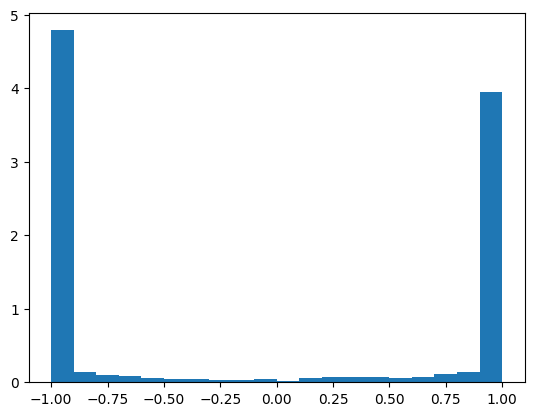

In [10]:
plt.hist(h_act.flatten().tolist(), 20, density=True)
plt.show()

<!-- Это тот самый "vanishing gradient", о котором мы ещё услышим позже, когда будем говорить про рекуррентные сети -->

Посмотрим на масштаб проблемы:

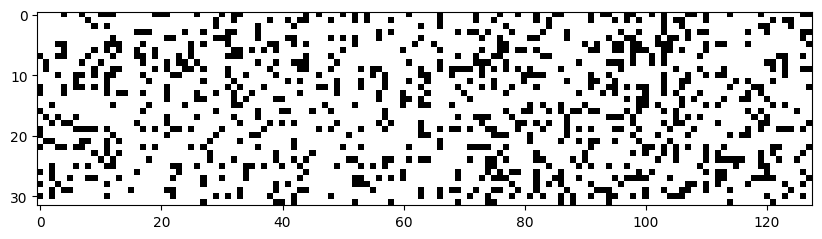

In [11]:
plt.figure(figsize=(10, 20))
plt.imshow(h_act.abs() > 0.99, cmap="gray")

Вспоминаем, что градиент по параметрам глубоко в вычислительном графе — это длинная цепочка произведений.

Везде, где пиксел белый, частная производная — одно из звеньев в цепочке — почти равна нулю.

Градиент будет уничтожен везде, где у нас белый пиксел.

А если найдётся целиком белый столбец — мы получим "мёртвый нейрон"!

**Упражнение**: Вернёмся в `__init__` модели и подберём стандартное отклонение для `w1`, которое даст нам красивое значение для гистограммы активаций (+- равномерно на интервале (-1, 1) с небольшими пиками около границ интервала) и картинку для активаций батча, где будет совсем немного белых пикселей.

#### 4. А как правильно?

Посмотрим, что происходит с распределением значений, когда мы перемножаем две матрицы, инициализированные стандартным нормальным распределением:

tensor(0.0068) tensor(1.0001)
tensor(0.0030) tensor(3.1896)


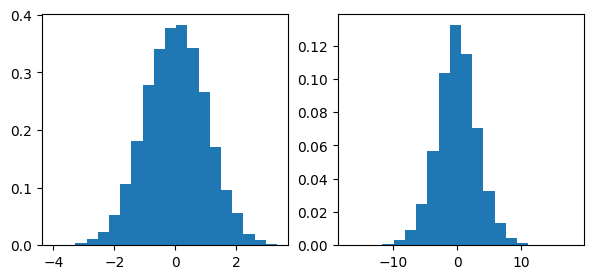

In [12]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y =  x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.hist(x.flatten().tolist(), 20, density=True)
ax2.hist(y.flatten().tolist(), 20, density=True)
plt.show()


Распределение расползлось, как исправить?


Ответ: Оказывается, нужно разделить на $\sqrt{d_{input}}$

На практике этого достаточно, но если хочется предельной точности: https://pytorch.org/docs/stable/nn.init.html
   $$\text{std} = \frac{\text{gain}(f_{act})}{\sqrt{\text{fan mode}}}$$

In [13]:
torch.nn.init.calculate_gain('tanh') / hidden_dim**0.5

0.1473139127471974

Посмотрим, есть ли проблемы с встроенным слоем `torch.nn.Linear`

In [14]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor, Tensor]:
        h = self.l1(x.flatten(1))
        h_act = F.tanh(h)
        logits = self.l2(h_act)
        return logits, h_act, h

In [15]:
torch.manual_seed(42)
x, y = next(iter(train_loader))
# создадим модель и выведем значение ошибки после инициализации
model = MLP(input_dim, hidden_dim, output_dim)
logits, h_act, h = model(x)
loss = F.cross_entropy(logits, y)
print(f"Initial loss: {loss:.4f}")

n_epochs = 10
batches_per_epoch = 100
for i in range(n_epochs):
    loss = train_epoch(train_loader, model, lr=0.1, max_batches=batches_per_epoch)
    print(f"Epoch {i} loss = {loss:.4f}")

print(f"Test loss: {test_epoch(test_loader, model, max_batches=batches_per_epoch):.4f}")

Initial loss: 2.3116
Epoch 0 loss = 1.1166
Epoch 1 loss = 0.5111
Epoch 2 loss = 0.4220
Epoch 3 loss = 0.3741
Epoch 4 loss = 0.3784
Epoch 5 loss = 0.3524
Epoch 6 loss = 0.3013
Epoch 7 loss = 0.3255
Epoch 8 loss = 0.3155
Epoch 9 loss = 0.3043
Test loss: 0.3521


Явных проблем нет: инициализация по умолчанию настроена хорошо!

#### Резюме
1. Проблемы с внутренними активациями возникают не только на инициализации, но и в процессе оптимизации - один большой шаг в неправильную сторону может убить нейрон (в случае с функцией активации ReLU - навсегда)
2. В маленьких моделях проблемы инициализации не так критичны - сеть в итоге обучится, просто потребуется больше времени.
3. Чем глубже сеть (больше слоёв) - тем больше проблем
4. Некоторые приёмы позволяют сгладить негативный эффект неудачной инициализации:
   1. residual connections
   2. normalization layers (`nn.BatchNorm`, `nn.LayerNorm`, `nn.GroupNorm`)
   3. лучшие оптимизаторы (RMSProp, Adam)